# Introduction

Cyclistic, a bike-share company in Chicago. The director of
marketing believes the company’s future success depends on maximizing the number of annual memberships. Therefore, your
team wants to understand how casual riders and annual members use Cyclistic bikes dierently. From these insights, your team
will design a new marketing strategy to convert casual riders into annual members. But first, Cyclistic executives must approve
your recommendations, so they must be backed up with compelling data insights and professional data visualizations.

# Phase 1 : Ask
**Key tasks**

**Identify the business task** : 
1. find the difference and the similarity between annual members and casual riders.
2. How can Cyclistic use digital media to influence casual riders to become members?

**Consider key stakeholders**
1. Lily Moreno: The director of marketing and my manager.
2. Cyclistic executive team : The notoriously detail-oriented executive team will decide whether to approve the recommended marketing program.




# Phase 2 : prepare 

In the analysys use different data from kaggle database because it's more up to date. 
download from this [**Link**](https://divvy-tripdata.s3.amazonaws.com/index.html).

* download data in zip file  named yyyymm-divvy-tripdata.zip from may 2020 to april 2021

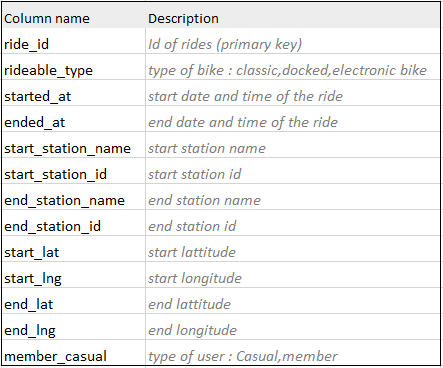

* check the data type of every column for each csv whether they are the same data type or not because it can be a problem when you try to combine the data. 
* Then found out that start_station_id and end_station_id of may-2020 to november-2020 data type are float when the rest are string

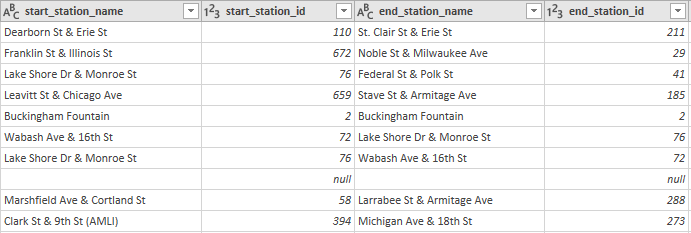
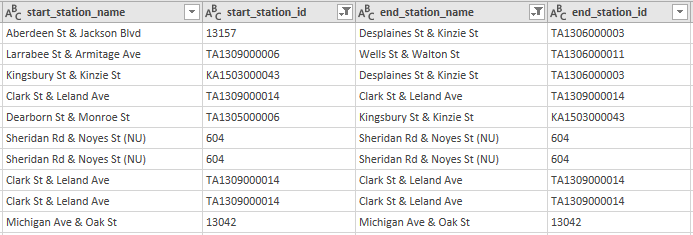

* so i decided to make every station id to string.
* Import the data to microsoft SQL server.


# Combine all of the data into single table.

In [ ]:
## Combine the data with Microsoft SQL Server ##

insert into divvy..cyclist_trip_0520_0421 (ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id
      ,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual)
select ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id
      ,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual 
from divvy..['202005-divvy-tripdata$']
union
select * 
from divvy..['202006-divvy-tripdata$']
union
select * 
from divvy..['202007-divvy-tripdata$']
union
select * 
from divvy..['202008-divvy-tripdata$']
union
select * 
from divvy..['202009-divvy-tripdata$']
union
select * 
from divvy..['202010-divvy-tripdata$']
union
select * 
from divvy..['202011-divvy-tripdata$']
union
select * 
from divvy..['202012-divvy-tripdata$']
union
select * 
from divvy..['202101-divvy-tripdata$']
union
select * 
from divvy..['202102-divvy-tripdata$']
union
select * 
from divvy..['202103-divvy-tripdata$']
union
select * 
from divvy..['202104-divvy-tripdata$']

#  Phase 3 : Process 

Add new colume and remove bad data.

In [ ]:
## create day_of week, ride_time, and trip_type column ##

alter table divvy..cyclist_trip_0520_0421
add day_of_week int;

update divvy..cyclist_trip_0520_0421
set day_of_week = datepart(weekday,started_at)

alter table divvy..cyclist_trip_0520_0421
add ride_time int;

update divvy..cyclist_trip_0520_0421
set ride_time = datediff(MINUTE,started_at,ended_at)

alter table divvy..cyclist_trip_0520_0421
add trip_type nvarchar(50) ;

update divvy..cyclist_trip_0520_0421
set trip_type = case when start_station_name = end_station_name then 'round trip'
				else 'one-way trip'
				End

select *
from divvy..cyclist_trip_0520_0421
where start_station_name = ' ' or end_station_name = ' '

## check ride_time ##

select max(ride_time),min(ride_time)
from divvy..cyclist_trip_0520_0421

select member_casual,started_at,ended_at
from divvy..cyclist_trip_0520_0421
where ride_time  < 0

##delete data having negative ride_time##

delete from divvy..cyclist_trip_0520_0421
where ride_time  < 0


## Ckeck lattitude and longitude for each station  ##

select distinct(start_station_name),start_lat,start_lng
from divvy..cyclist_trip_0520_0421
order by start_station_name desc


previous query shows that there are various location(latitude and longtitude) for one station nam

so i use station location data from **Chicago Data Portal** instead : [Link](https://data.cityofchicago.org/Transportation/Divvy-Bicycle-Stations-All-Map/bk89-9dk7)

and import with name : **Divvy_Bicycle_Stations_-_All**

# Phase 4 : Analyze

Program used in this phase
* **Microsoft SQLs Server Management Studio** to query the data 
* **Tableau** to visualize the data

In [ ]:
## query average ride_time  for each usertype ##

select member_casual as user_type,trip_type,avg(ride_time) as average_time,count(*) as number_of_ride
from divvy..cyclist_trip_0520_0421
where start_station_name != ' ' or end_station_name! = ' '
group by member_casual,trip_type
order by 1,4 desc


## query daily(weekday) number_of_ride for each user type ##

select member_casual as user_type,day_of_week,avg(ride_time) as average_time,count(*) as number_of_ride
from divvy..cyclist_trip_0520_0421
group by member_casual,day_of_week
order by user_type,day_of_week 

## query daily(weekday) number_of_ride for each user type but month scale (incase that user behavior change overtime) ##

select member_casual as user_type,datepart(year,started_at) as year,datepart(month,started_at) as month,day_of_week,avg(ride_time) as average_time,count(*) as number_of_ride
from divvy..cyclist_trip_0520_0421
group by member_casual,day_of_week,datepart(year,started_at),datepart(month,started_at)
order by 1,2,3,4




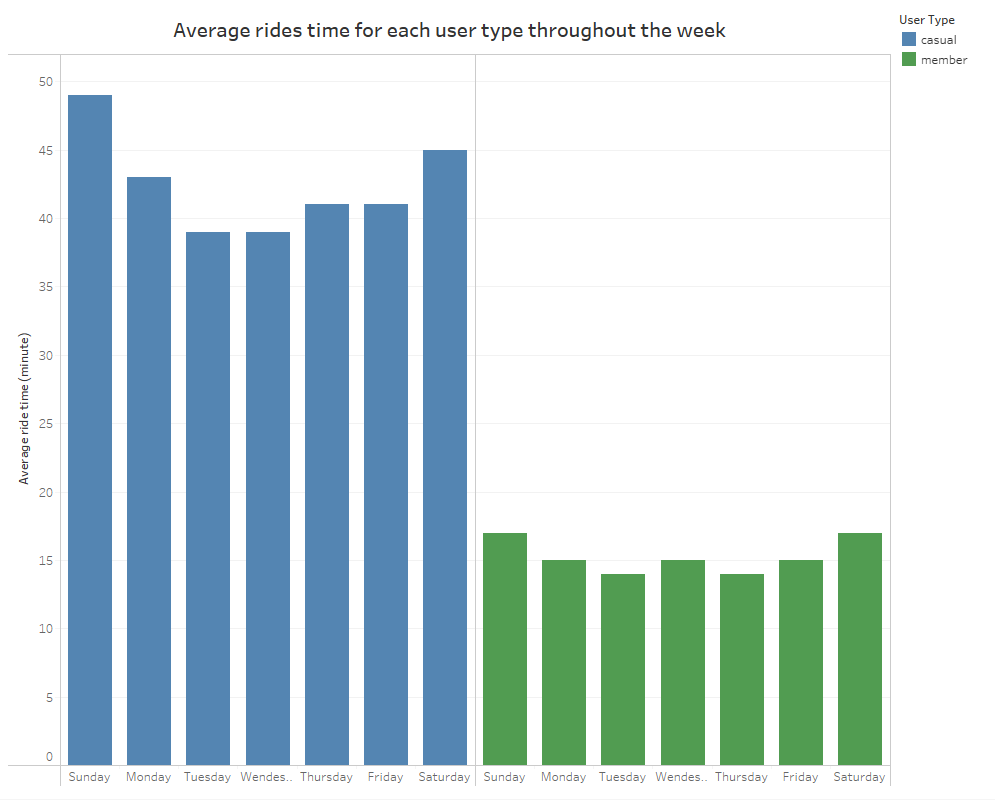

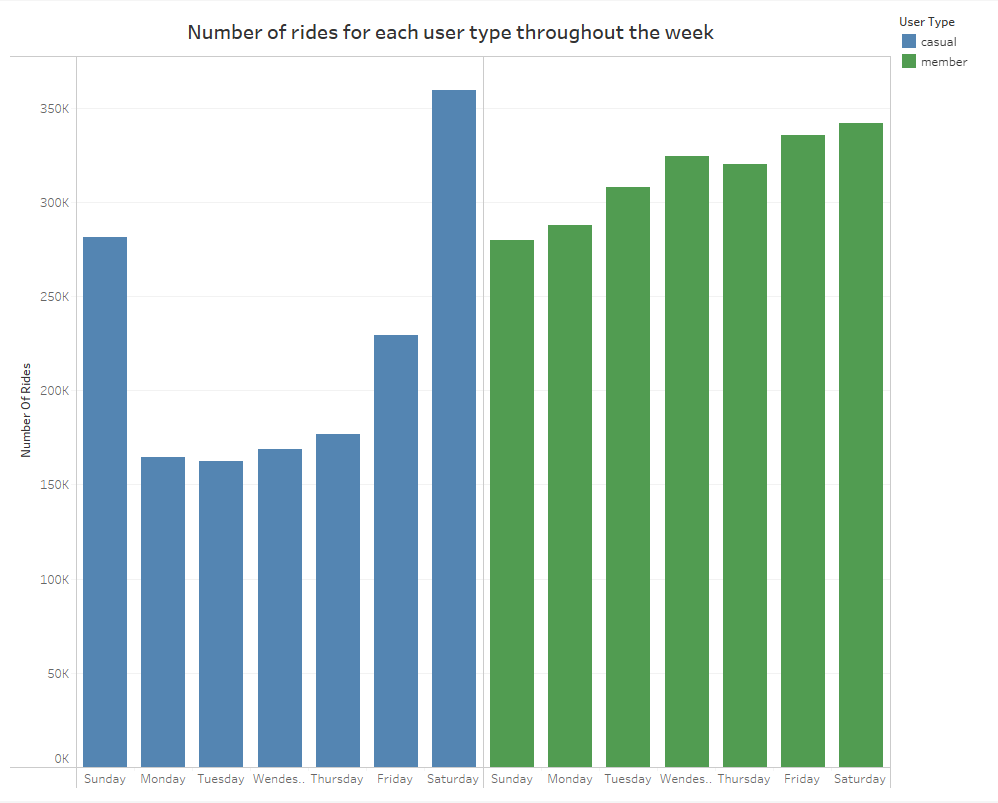

**Analyze and Hypothesis**

**Casual users** tend to have a higher number of rides on the weekend and have higher ride duration than member users. While **member users** have even rides number throughout the week with short duration.


In [ ]:
select top(150) t.start_station_name,t.end_station_name,count(*) as number,l1.longitude as start_lng,l1.latitude as start_lat,l2.longitude as end_lng,l2.latitude as end_lat,t.member_casual,t.trip_type
from divvy..cyclist_trip_0520_0421 t 
join divvy..['Divvy_Bicycle_Stations_-_All_-_$'] l1 on t.start_station_name = l1.station_name
join divvy..['Divvy_Bicycle_Stations_-_All_-_$'] l2 on t.end_station_name = l2.station_name
where start_station_name != ' ' and member_casual = 'casual' and trip_type = 'one-way trip'
group by t.start_station_name,t.end_station_name,t.member_casual,l1.longitude,l1.latitude,l2.longitude,l2.latitude,t.trip_type
order by number desc

select top(150) t.start_station_name,t.end_station_name,count(*) as number,l1.longitude as start_lng,l1.latitude as start_lat,l2.longitude as end_lng,l2.latitude as end_lat,t.member_casual,t.trip_type
from divvy..cyclist_trip_0520_0421 t 
join divvy..['Divvy_Bicycle_Stations_-_All_-_$'] l1 on t.start_station_name = l1.station_name
join divvy..['Divvy_Bicycle_Stations_-_All_-_$'] l2 on t.end_station_name = l2.station_name
where start_station_name != ' ' and member_casual = 'member' and trip_type = 'one-way trip'
group by t.start_station_name,t.end_station_name,t.member_casual,l1.longitude,l1.latitude,l2.longitude,l2.latitude,t.trip_type
order by number desc

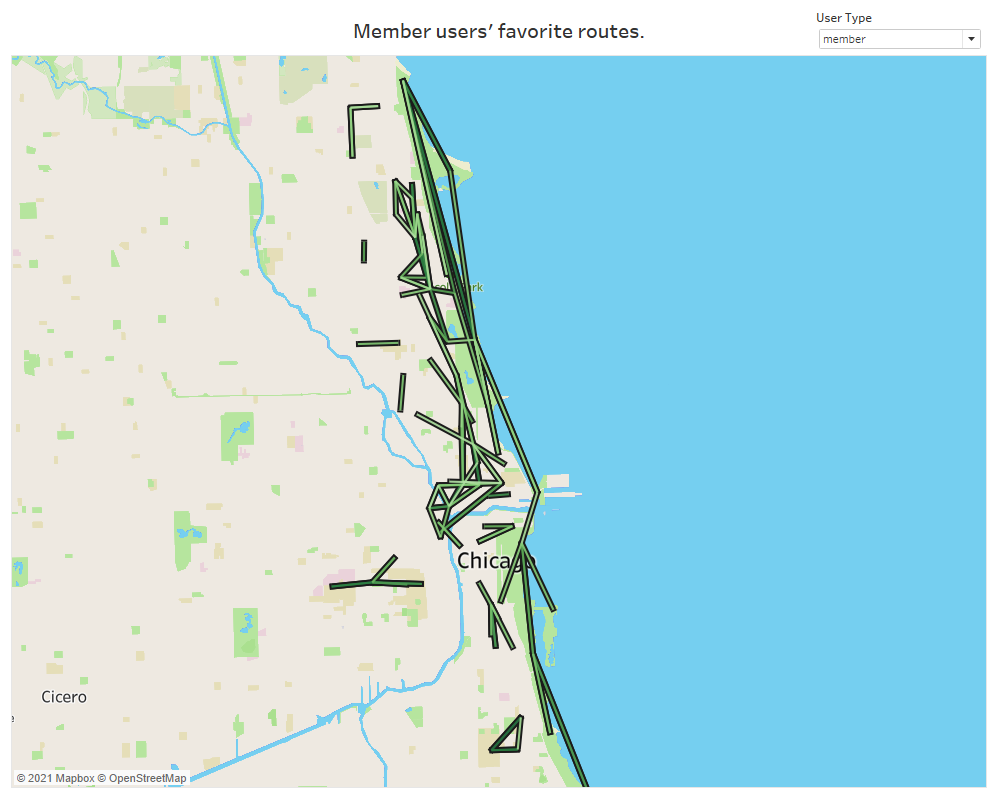
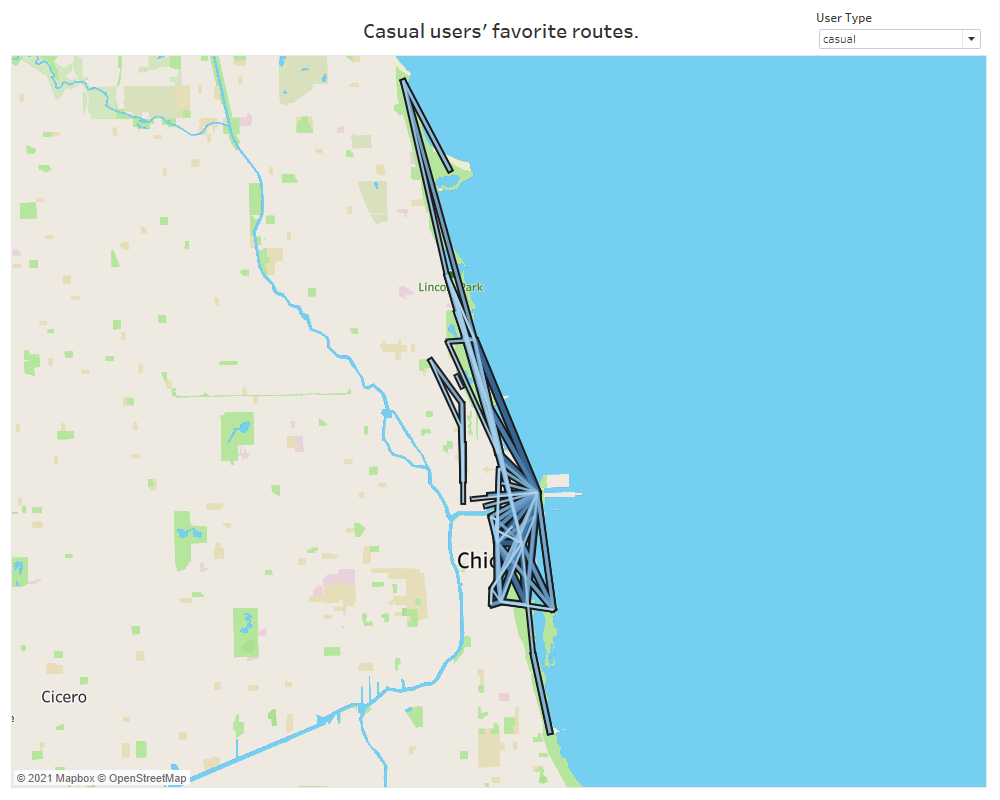

Geographic visualization shows that favorite routes for casual users are park focused (center of the city). Member users' favorite routes are more balance between park area and outskirt such as university.

# Phase 5 : Share

**The difference between member and causl users**
* Casual users have significantly higher ride duration than member users.
* Casual users have higher ride numbers in weekend while more even throughout the week
* Casual users favorite route are mostly between park and attractions.
* Member users favorite route are around the city.

**Conclusion** 
Casual users use bike service for traveling and sightseeing.
while member users use the service for daily transportation.(also traveling)



# Phase 6 : Act

Approach of this act is to make customer think that they will use the service **more often** that it is reasonable to buy anual membership **(more convenient,save money)**.

Digital media campaign will promote behavior both of the user type (Causual and Member)
1. **Member user behavior** : have a campaign that encouage casual user to use bike in daily life such as commute to work,study,and shopping especially unviversity students because they have to travel across the university to study different subject.
2. **Causual user behaviors** : Have social media content about Chicago's **attractions**. It at first making a lists of parks and attactions that have divvy's bike station nearby. They can do target marketing by making a **calendar of events** that can travel with bike sharing service from **customer interests**.
